In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import os
import matplotlib
import pandas as pd
import scipy.stats
%matplotlib inline

# Trend calculation for NOAA station temperature records

First we load information about the stations, such as the name and location.

In [2]:
# Open ascii text data
f = open('ghcnm.v3.first.last')

# Set up dictionary
station_info = {'id':[], 'lat':[],'lon':[],'elev':[],'firstyear':[],'lastyear':[], 'nyear':[],'name':[]}

counter = 0
# For each line
for line in f:
    if counter > 0:
        # entries separated by spaces, discarding extra spaces
        l_line = [l for l in line.split(' ') if not l is '']
        station_info['id'].append(int(l_line[0])) # Station ID
        station_info['lon'].append(float(l_line[1])) # longitude
        station_info['lat'].append(float(l_line[2])) # Latitude
        station_info['elev'].append(float(l_line[3])) # Elevation
        station_info['firstyear'].append(int(l_line[5])) # First year in record
        station_info['lastyear'].append(int(l_line[6])) # Last year in record
        station_info['nyear'].append(int(l_line[7])) # number of years in the record
        station_info['name'].append(' '.join(l_line[8:-1])) # There can be spaces in the names, so add together the rest of the strings
    counter+=1


Next, load the data. The data is in text format, with each line corresponding to a station and a year. 

sample line:

101603550001878TAVG  960  1 1020  1 1180  1 1680  1 2050  1 2310  1 2560  1 2750  1 2390  1-9999 Q1 1440  1 1220  1

The data is in Celcius, multiplied by 100. Each data value is followed by a 2 digit code with flags for data sources and quality control (ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/v3/README). I will ignore the flags for now.

In [3]:
# Load text file
f = open('ghcnm.v3.3.0.20181112/ghcnm.tavg.v3.3.0.20181112.qca.dat')

# set an arbitrary first year
y0 = 1800

# Dictionary with data
data = {i:{'time':[],'data':[]} for i in station_info['id']}

# For each line
for line in f:
    # Get the station ID
    ID = int(line[:11])
    
    # get the year
    y = int(line[11:15])
    
    # initial column for data
    i0 = 19
    
    if ID in data.keys():
        # for each month in the year
        for m in range(12):
            # Eight characters for each entry, 5 for the data, 3 for the flags.
            n1 = i0 + m*8
            n2 = i0 + m*8 + 5
            
            # Append time as the number of months since the start date (1800)
            data[ID]['time'].append((y-y0)*12 + m)
            # Convert 5 character string to a int and divide by 100
            data[ID]['data'].append(int(line[n1:n2])/100.)

Identify stations within a selected lat/lon box.

In [5]:
sel_data = []

# Selection box
lonrange = [-170,-50]
latrange = [10,90]

# For all the stations
for i in range(len(station_info['id'])):
    # Check lat and lon coordinates
    lat = station_info['lat'][i]
    lon = station_info['lon'][i]
    
    # If in the selection box, add to the list
    if lat > latrange[0] and lat < latrange[1] and lon > lonrange[0] and lon < lonrange[1]:
        sel_data.append((i,station_info['id'][i],lat,lon))

Calculate the average for each year in each station's record, excluding years where there is missing data (missing data is denoted by a -99.99 value).

In [8]:
yearmean = {}

# Length of each month
mon_length = np.array([31,28,31,30,31,30,31,31,30,31,30,31])

# For each selected station
for i,ID,lat,lon in sel_data:
    time = data[ID]['time']
    d = data[ID]['data']
    
    # Get length of the time series (in months)
    ntime = len(time)
    yearmean[ID] = {'year':[],'tavg':[]}

    # For each year (thus divide ntime by 12)
    for year in range(ntime//12):
        # Get the months for the selected year
        asd = d[year*12:year*12+12]
        # If there are entries below -90 in the record, we skip the entire year
        if np.all(np.array(asd) > -90):
            yearmean[ID]['year'].append(time[year*12]//12+y0)
            # average the monthly values, weighted by the length of each month (skipping leap years)
            yearmean[ID]['tavg'].append(np.average(asd,weights = mon_length))
    

Calculate linear regression for each station, where we are using stations with more than 50 years of data, regardless of the years over which the data are recorded. Thus, some are 1967 to 2017, while others might be 1950 to 2000, missing the last 18 years for some reason.

In [13]:
trend = {'slope':{},'p_value':{},'lastyear':{}}

# For each selected station
for i,ID,lat,lon in sel_data:
    years = np.array(yearmean[ID]['year'])
    tavgs = np.array(yearmean[ID]['tavg'])
    
    # Index of station in the station_info arrays
    ind_stat = np.argwhere(np.array(station_info['id']) == ID)
    
    # If the range of years in the station record is greater than 50 years
    if station_info['lastyear'][ind_stat]-station_info['firstyear'][ind_stat] > 50:
        # Exclude station records whether there are many missing years
        if len(years)>20:
            # Calculate slope and p_value using scipy.stats
            slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(years,tavgs)
            trend['slope'][ID] = slope
            trend['p_value'][ID] = p_value
            trend['lastyear'][ID] = station_info['lastyear'][ind_stat]

/home/haruki/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/home/haruki/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


Categorize the stations based on if they have positive, negative, or no significant trends at a p < 0.05 level. Also select stations whose last year is after 2000.

In [18]:
postrend = [(lat,lon,trend['slope'][ID]) for i,ID,lat,lon in sel_data if ID in trend['p_value'] and trend['slope'][ID] > 0 and trend['p_value'][ID] < 0.05 and trend['lastyear'][ID]>2000]
notrend = [(lat,lon,trend['slope'][ID]) for i,ID,lat,lon in sel_data if ID in trend['p_value'] and trend['p_value'][ID] > 0.05 and trend['lastyear'][ID]>2000]
negtrend = [(lat,lon,trend['slope'][ID]) for i,ID,lat,lon in sel_data if ID in trend['p_value'] and trend['slope'][ID] < 0 and trend['p_value'][ID] < 0.05 and trend['lastyear'][ID]>2000]



Generate plot with Matplotlib + Basemap

0.622360248447205
0.040372670807453416


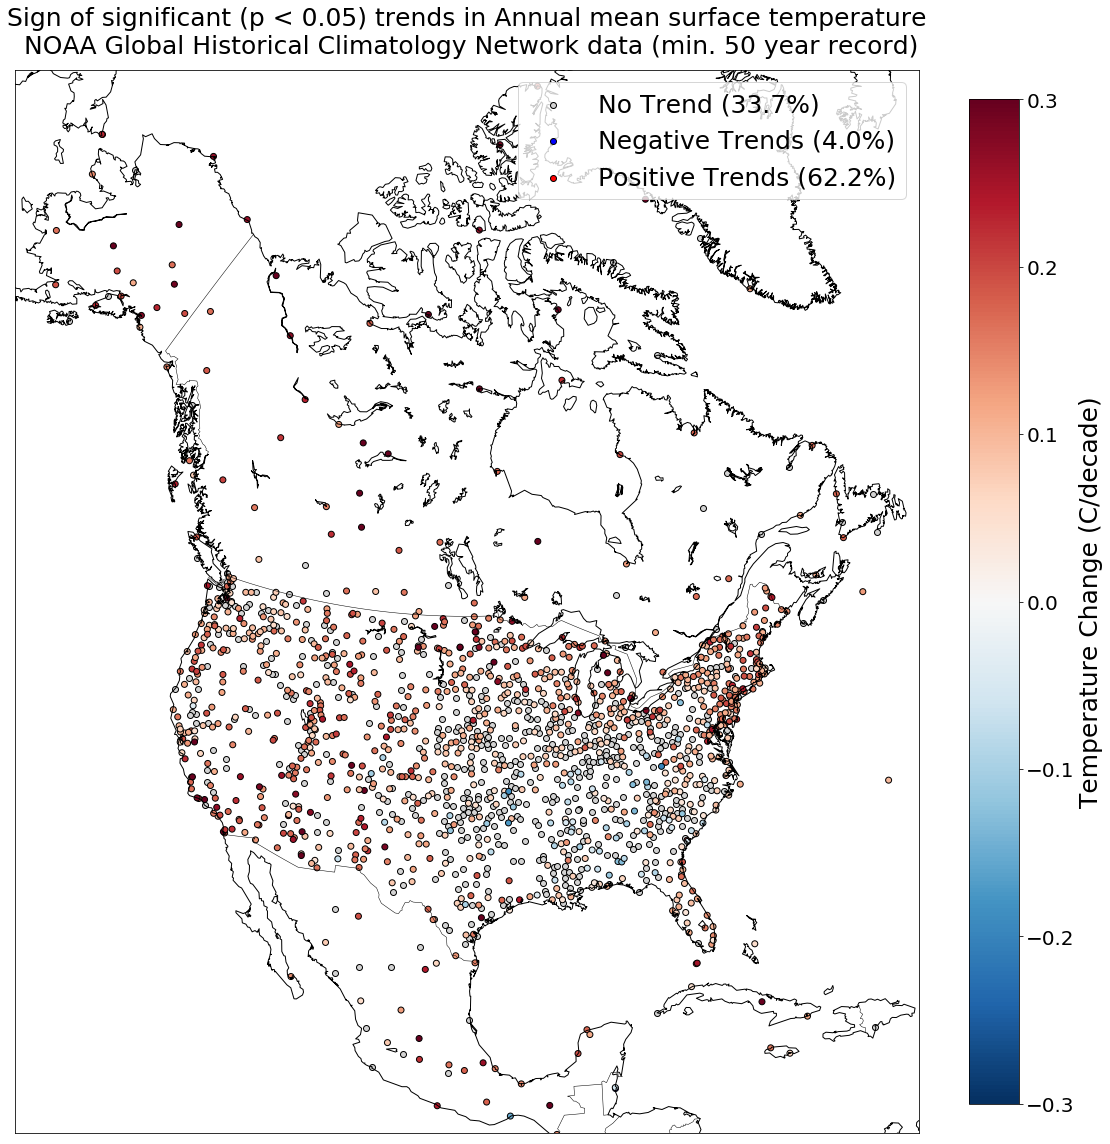

In [20]:
# Set up plot
fig,ax = plt.subplots(1,1,figsize=(18,20))
map1 = Basemap(ax = ax,width=6800000,height=8000000,
                resolution='l',projection='stere',\
                lat_ts=50,lat_0=50,lon_0=-98.)

# Draw boundaries/coasts
map1.drawcoastlines()
map1.drawcountries()

# Percentage of stations with postive/negative trend
tot = len(postrend)+len(negtrend)+len(notrend)
print(len(postrend)/tot)
print(len(negtrend)/tot)

# Plotting location of stations without significant trends
mlons,mlats = map1(np.array(notrend)[:,1],np.array(notrend)[:,0])
map1.scatter(mlons,mlats,c='lightgrey',label = 'No Trend ({0:2.1f}%)'.format(len(notrend)*100/tot), 
             linewidths=1,edgecolor='k')

# place dots for positive/negative trends for the legend
if len(negtrend) > 0:
    mlons,mlats = map1(np.array(negtrend)[0,1],np.array(negtrend)[0,0])
    map1.scatter(mlons,mlats,c='b',label = 'Negative Trends ({0:2.1f}%)'.format(len(negtrend)*100/tot),
                 linewidths=1,edgecolor='k')
else:
    mlons,mlats = map1(0,0)
    map1.scatter(mlons,mlats,c='b',label = 'Negative Trends ({0:2.1f}%)'.format(len(negtrend)*100/tot),
                 linewidths=1,edgecolor='k')
    
mlons,mlats = map1(np.array(postrend)[0,1],np.array(postrend)[0,0])
map1.scatter(mlons,mlats,c='r',label = 'Positive Trends ({0:2.1f}%)'.format(len(postrend)*100/tot),linewidths=1,edgecolor='k')

# Plotting location of stations with significant trends, colored based on the magnitude of the trend in Celcius per Decade
mlons,mlats= map1(np.array(postrend+negtrend)[:,1],np.array(postrend+negtrend)[:,0])
sc = map1.scatter(mlons,mlats,c = np.array(postrend+negtrend)[:,2]*10,vmax = 0.3,vmin =-0.3,
             cmap = 'RdBu_r'.format(len(negtrend)*100/tot),linewidths=1,edgecolor='k')

# Add colorbar
cax, _ = matplotlib.colorbar.make_axes(ax,location='right',pad=0.05,fraction = 0.05)
plt.colorbar(sc,cax=cax)
cax.tick_params(labelsize=20)
cax.set_ylabel('Temperature Change (C/decade)',fontsize=25)

# Add legend and title
ax.legend(fontsize=25)
ax.set_title('Sign of significant (p < 0.05) trends in Annual mean surface temperature\n'+
             ' NOAA Global Historical Climatology Network data (min. 50 year record)',fontsize=25, y=1.01)

Notes on the results:

I wanted to perform an analysis of temperatures to show in the most basic terms the observed warming of surface temperatures. Here, I have plotted the sign of the trends in annual mean temperature change for individual stations in NOAA's GHCNM. We see that even at the level of individual stations, we have statistically significant warming at a majority of stations, both in urban areas, which would also be affected by the urban heat island effect (e.g. Los Angeles), and far-flung rural stations (e.g. Utqiagvik, Alaska).

Q) Why are there so few stations with data outside of the US?
    
A) Presumably because the agency that collated this data is US-based. For example, there are many Canadian stations in the data set, but they don't have more recent data.

Q) Why are there stations with negative trends? Isn't the climate warming?

A) Even if we were in an unchanging climate, we would expect some of stations to have positive and negative trends due the natural internal variability of the climate (e.g. year-to-year changes). Thus, it is natural to expect some stations with negative trends, though if we change the minimum end year to something closer to the present, say 2015, we see a reduction in the number of stations with statistically significant negative trends.

Q) Why does the South East US warm less than the rest of the country?

A) This is a phenomenon known as the South East US warming hole that occurred in the second half of the 20th century and appears to have been due to long-term variations in ocean temperatures (e.g. [Meehl et al., 2015](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2015GL064586)).

In [327]:
i = np.argmax(np.array([trend['slope'][ID] for ID in trend['slope']])[:])
ID = list(trend['slope'].keys())[i]
name = station_info['name'][np.argwhere(np.array(station_info['id']) == ID)]
print(name)

BARROW/W.


/home/haruki/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  app.launch_new_instance()


In [365]:
i = np.argsort(np.array([trend['slope'][ID] for ID in trend['slope']])[:])[-10:]
ID = np.array(list(trend['slope'].keys()))[i]
names = [(station_info['name'][np.argwhere(np.array(station_info['id']) == asd)],trend['slope'][asd]) for asd in ID]
print(names)

[('BETHEL/BETHEL', 0.04579381681351704), ('PASADENA', 0.047370725593885894), ('KING SALMON', 0.049573430222260503), ('CAMBRIDGE BAY', 0.049599292744614672), ('LAS VEGAS/MCC', 0.05133913912769917), ('MADISON/DANE', 0.051358223289315726), ('SAN DIEGO/LIN', 0.052605909463981339), ('FORT STANTON USA', 0.05998618515780052), ('MCGRATH', 0.060674137874602539), ('BARROW/W. POS', 0.07980783002813599)]


/home/haruki/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  app.launch_new_instance()


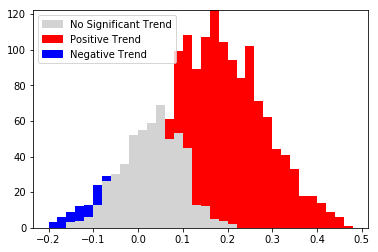

In [379]:
from matplotlib.patches import Rectangle
N, bins, patches = plt.hist([np.array(notrend)[:,2]*10,np.array(postrend)[:,2]*10,np.array(negtrend)[:,2]*10],np.arange(-0.2,0.5,0.02),
         stacked=True)
for p in patches[0]: p.set_facecolor('lightgrey')
for p in patches[1]: p.set_facecolor('red')
for p in patches[2]: p.set_facecolor('blue')

handles = [Rectangle((0,0),1,1,color=c) for c in ['lightgrey','red','blue']]
labels= ["No Significant Trend","Positive Trend", "Negative Trend"]
plt.legend(handles, labels)

In [374]:
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in [low,medium, high]]
labels= ["low","medium", "high"]
plt.legend(handles, labels)

<Container object of 34 artists>